In [1]:
import geopandas as gpd
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from adjustText import adjust_text
from scipy.stats import kendalltau, pearsonr

C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
country = "France"
year = 2022
location_level = "department"

colors = json.load(open("consts.json", encoding="utf-8"))

In [3]:
gdf = gpd.read_file(f"geo_shapes/{country}_{location_level}.gpkg")
gdf.head()

,department_id,department,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.79458 46.21832, ..."
1,02,Aisne,"POLYGON ((4.04797 49.40564, 4.03991 49.39740, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.04907 46.75808, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.69209 44.18648, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.29922 45.10855, ..."


In [4]:
df = pd.read_csv(f"data_output/{country}/{year}_divisiveness_{location_level}.csv.gz", compression="gzip")
df = df.dropna()
df.head()

,department,candidate,value
0,Ain,Emmanuel MACRON,0.057835
1,Ain,Fabien ROUSSEL,0.012062
2,Ain,Jean LASSALLE,0.018615
3,Ain,Jean-Luc MÉLENCHON,0.063000
4,Ain,Marine LE PEN,0.068983


In [5]:
df_fround = pd.read_csv(f"data_output/{country}/{year}_first_round.csv.gz", compression="gzip")
df_fround.columns = [x.lower() for x in df_fround.columns]

df_runoff = pd.read_csv(f"data_output/{country}/{year}_runoff.csv.gz", compression="gzip")
df_runoff.columns = [x.lower() for x in df_runoff.columns]

candidate_a, candidate_b = df_runoff.candidate.unique()
df_location = pd.read_csv(f"data_output/{country}/{year}_first_round_location.csv.gz", compression="gzip")

df_fround = pd.merge(df_fround, df_location, on="polling_id")
df_runoff = pd.merge(df_runoff, df_location, on="polling_id")

df_fround[location_level] = df_fround[location_level].replace({
    "BIOBIO": "BIO-BIO",
    "CHAÑARAL": "CHANARAL",
    "DEL TAMARUGAL": "TAMARUGAL",
    "SAN FELIPE DE ACONCAGUA": "SAN FELIPE"
})
df_runoff[location_level] = df_runoff[location_level].replace({
    "BIOBIO": "BIO-BIO",
    "CHAÑARAL": "CHANARAL",
    "DEL TAMARUGAL": "TAMARUGAL",
    "SAN FELIPE DE ACONCAGUA": "SAN FELIPE"
})

C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(-5.836766828932491, 10.292887003465472, 40.880987627579636, 51.57446967069947)

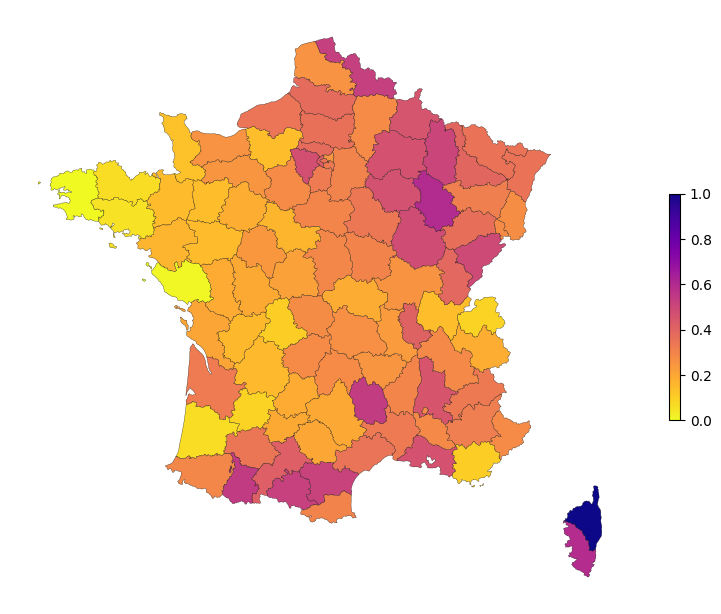

In [6]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

data_tmp = df.groupby(["department"]).agg({"value": "mean"}).reset_index()
data_tmp = pd.merge(data_tmp, gdf, on="department")

data_tmp = gpd.GeoDataFrame(data_tmp)
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

data_tmp["value"] = NormalizeData(data_tmp["value"])

data_tmp.plot(
    column="value", 
    edgecolor="black",
    cmap="plasma_r",
    lw=0.2,
    ax=ax, 
    legend=True, 
    legend_kwds=dict(
        shrink=0.3
    )
)

plt.axis("off")

(-5.836766828932491, 10.292887003465472, 40.880987627579636, 51.57446967069947)

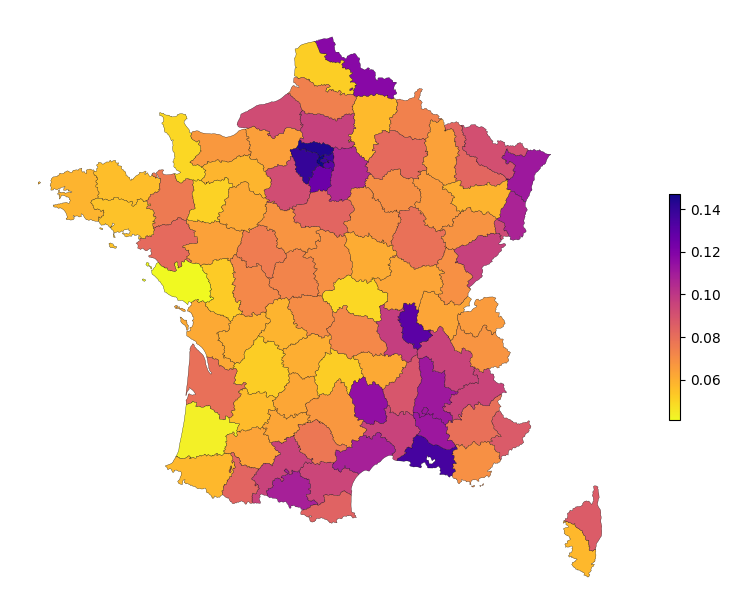

In [7]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

data_tmp = df[df["candidate"] == "Jean-Luc MÉLENCHON"]
data_tmp = pd.merge(data_tmp, gdf, on="department")

data_tmp = gpd.GeoDataFrame(data_tmp)
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data_tmp.plot(
    column="value", 
    edgecolor="black",
    cmap="plasma_r",
    lw=0.2,
    ax=ax, 
    legend=True, 
    legend_kwds=dict(
        shrink=0.3
    )
)

plt.axis("off")

In [8]:
df["rank"] = df.groupby("department")["value"].rank(ascending=False).astype(int)
df

,department,candidate,value,rank
0,Ain,Emmanuel MACRON,0.057835,3
1,Ain,Fabien ROUSSEL,0.012062,9
2,Ain,Jean LASSALLE,0.018615,7
3,Ain,Jean-Luc MÉLENCHON,0.063000,2
4,Ain,Marine LE PEN,0.068983,1
...,...,...,...,...
958,Yvelines,Marine LE PEN,0.065786,3
959,Yvelines,Nicolas DUPONT-AIGNAN,0.007643,9
960,Yvelines,Valérie PÉCRESSE,0.037066,5
961,Yvelines,Yannick JADOT,0.020117,6


(-5.836766828932491, 10.292887003465472, 40.880987627579636, 51.57446967069947)

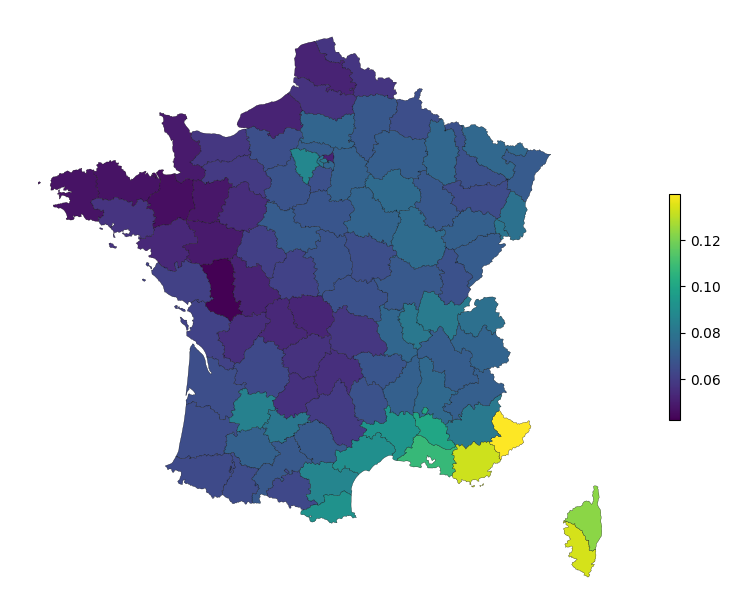

In [9]:
# df_fround["rank"] = df_fround.groupby([location_level, "candidate"]).agg({"value": "sum"}).groupby(level=0)["value"].rank(ascending=False).astype(int)
#df_fround.groupby(location_level)["value"].rank(ascending=False).astype(int)

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
dd = df_fround.groupby([location_level, "candidate"]).agg({"value": "sum"})
dd["rate"] = dd.groupby(level=[0]).apply(lambda x: x/x.sum())

dd["rank"] = dd.groupby(level=0)["value"].rank(ascending=False).astype(int)
dd = dd.reset_index()

data_tmp = dd[dd["candidate"] == "Éric ZEMMOUR"]
data_tmp = pd.merge(data_tmp, gdf, on=location_level)
data_tmp["color"] = data_tmp["candidate"].replace(colors)

data_tmp = gpd.GeoDataFrame(data_tmp)
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data_tmp.plot(
    column="rate",
    # color=data_tmp["color"],
    edgecolor="black",
    lw=0.2,
    ax=ax, 
    legend=True, 
    legend_kwds=dict(
         shrink=0.3
    )
)

plt.axis("off")

C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(-5.836766828932491, 10.292887003465472, 40.880987627579636, 51.57446967069947)

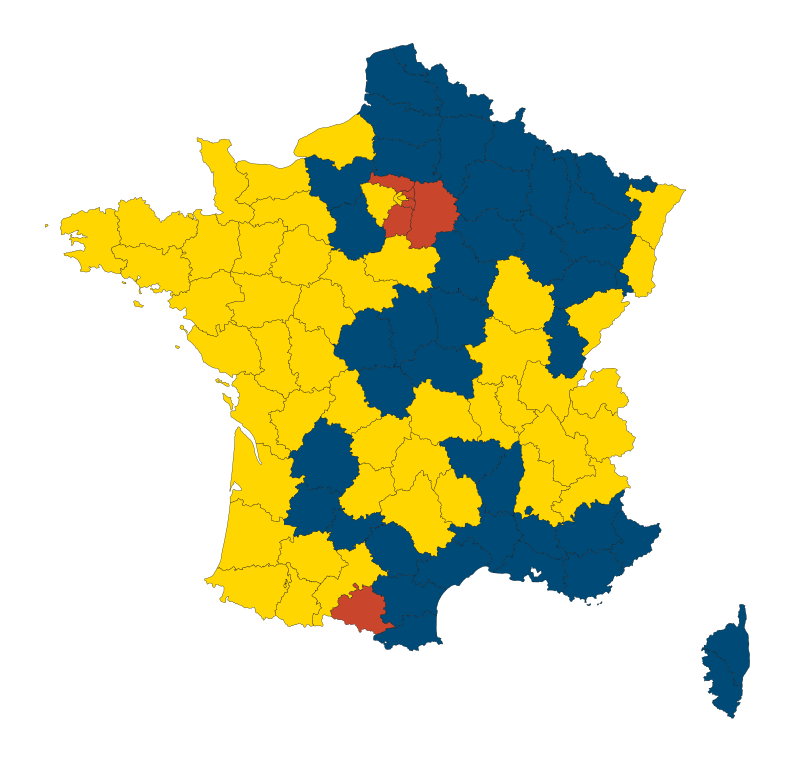

In [10]:
# df_fround["rank"] = df_fround.groupby([location_level, "candidate"]).agg({"value": "sum"}).groupby(level=0)["value"].rank(ascending=False).astype(int)
#df_fround.groupby(location_level)["value"].rank(ascending=False).astype(int)

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
dd = df_fround.groupby([location_level, "candidate"]).agg({"value": "sum"})
dd["rank"] = dd.groupby(level=0)["value"].rank(ascending=False).astype(int)
dd = dd.reset_index()

data_tmp = dd[dd["rank"] == 1]
data_tmp = pd.merge(data_tmp, gdf, on=location_level)
data_tmp["color"] = data_tmp["candidate"].replace(colors)

data_tmp = gpd.GeoDataFrame(data_tmp)
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data_tmp.plot(
    column="candidate",
    color=data_tmp["color"],
    edgecolor="black",
    lw=0.2,
    ax=ax, 
    legend=True, 
    legend_kwds=dict(
#         shrink=0.3
    )
)

plt.axis("off")

C:\Users\cnavarreteliz\AppData\Roaming\Python\Python39\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(-5.836766828932491, 10.292887003465472, 40.880987627579636, 51.57446967069947)

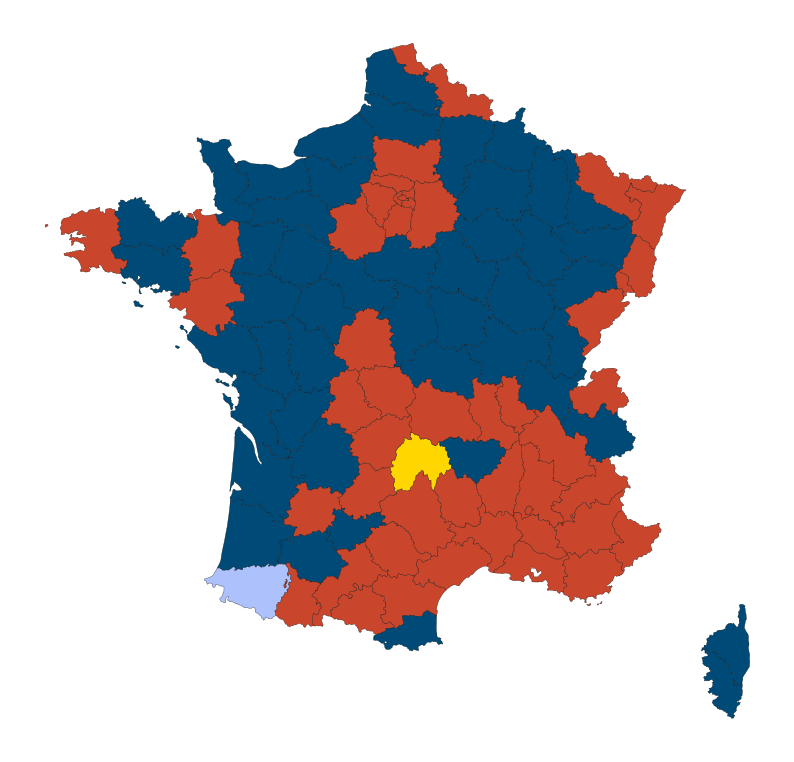

In [11]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

data_tmp = df[df["rank"] == 1]
data_tmp = pd.merge(data_tmp, gdf, on="department")
data_tmp["color"] = data_tmp["candidate"].replace(colors)
data_tmp = gpd.GeoDataFrame(data_tmp)

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data_tmp.plot(
    column="candidate",
    color=data_tmp["color"],
    edgecolor="black",
    lw=0.2,
    ax=ax, 
    legend=True, 
    legend_kwds=dict(
#         shrink=0.3
    )
)

plt.axis("off")

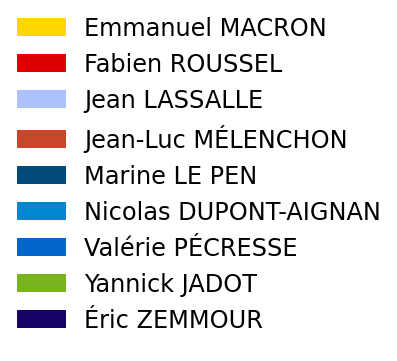

In [12]:
#Imports
import matplotlib.patches as mpatches

# where some data has already been plotted to ax
handles, labels = ax.get_legend_handles_labels()

for key in colors.keys():
    if key in df["candidate"].unique():
        value = colors[key]
        patch = mpatches.Patch(color=value, label=key)
        handles.append(patch) 
        
legend = plt.legend(handles=handles, loc='lower center', fontsize=24, frameon=False, ncol=1)

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # fig.savefig(filename, dpi="figure", bbox_inches=bbox)

plt.axis("off")
# export_legend(legend)
# plt.show()
legend

In [13]:
# ee = df[df["candidate"].isin(df_runoff.candidate.unique())]
# ee = ee.pivot(index=location_level, columns="candidate", values="value").reset_index()
# ee
df_transition = pd.read_csv(f"data_transition/{country}_{year}_commune_id_expanded.csv", encoding="latin-1")
df_transition.head()

,Unnamed: 0,Nathalie.ARTHAUD.Emmanuel.MACRON,Fabien.ROUSSEL.Emmanuel.MACRON,Emmanuel.MACRON.Emmanuel.MACRON,Jean.LASSALLE.Emmanuel.MACRON,Marine.LE.PEN.Emmanuel.MACRON,Éric.ZEMMOUR.Emmanuel.MACRON,Jean.Luc.MÉLENCHON.Emmanuel.MACRON,Anne.HIDALGO.Emmanuel.MACRON,Yannick.JADOT.Emmanuel.MACRON,...,Jean.LASSALLE.Marine.LE.PEN,Marine.LE.PEN.Marine.LE.PEN,Éric.ZEMMOUR.Marine.LE.PEN,Jean.Luc.MÉLENCHON.Marine.LE.PEN,Anne.HIDALGO.Marine.LE.PEN,Yannick.JADOT.Marine.LE.PEN,Valérie.PÉCRESSE.Marine.LE.PEN,Philippe.POUTOU.Marine.LE.PEN,Nicolas.DUPONT.AIGNAN.Marine.LE.PEN,commune_id
0,1,0.0,0.0,0.903904,0.0,0.0,0.187197,0.822432,0.0,0.964152,...,0.591447,0.995205,0.677440,0.174670,0.0,0.0,0.083099,0.0,0.817323,01001
1,2,0.0,0.0,0.969824,0.0,0.0,0.191137,0.835419,0.0,0.970033,...,0.663838,0.964227,0.671859,0.161559,0.0,0.0,0.073076,0.0,NaN,01002
2,3,0.0,0.0,0.929724,0.0,0.0,0.176931,0.796289,0.0,0.961384,...,0.660303,0.977158,0.689991,0.201496,0.0,0.0,0.087418,0.0,0.845935,01004
3,4,0.0,0.0,0.886053,0.0,0.0,0.171817,0.798627,0.0,0.956662,...,0.656509,1.000000,0.698040,0.199054,0.0,0.0,0.097564,0.0,0.847524,01005
4,5,NaN,0.0,0.954245,0.0,0.0,0.188924,0.863002,0.0,0.973136,...,0.657851,0.952263,0.671720,0.134003,0.0,0.0,0.084175,NaN,0.841193,01006


KeyError: 'department'

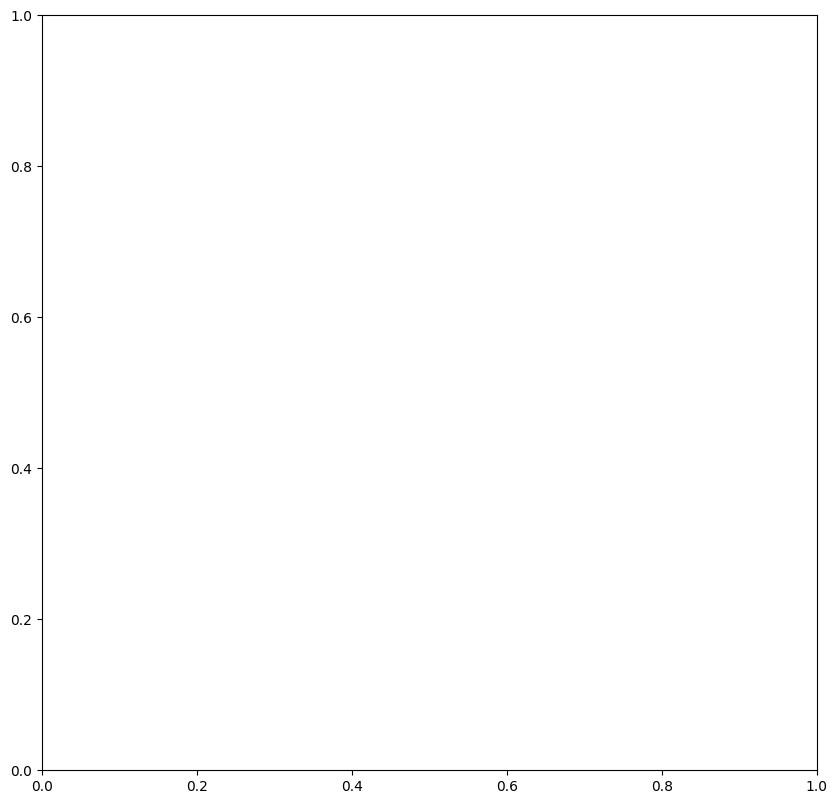

In [14]:

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

data_tmp = pd.merge(df_transition, gdf, on="department")

data_tmp = gpd.GeoDataFrame(data_tmp)
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data_tmp.plot(
    column="Éric.ZEMMOUR.Marine.LE.PEN", 
    edgecolor="black",
    cmap="plasma_r",
    lw=0.2,
    ax=ax, 
    legend=True, 
    legend_kwds=dict(
        shrink=0.3
    )
)

plt.axis("off")

In [ ]:
endorsements = {
    "Emmanuel MACRON": [("Anne HIDALGO", "Yannick JADOT", "Valérie PÉCRESSE"), ("Jean-Luc MÉLENCHON", "Philippe POUTOU", "Fabien ROUSSEL")],
    "Marine LE PEN": [("Nicolas DUPONT-AIGNAN", "Éric ZEMMOUR"), ()]
}

aa = df_fround[df_fround["candidate"].isin(endorsements[candidate_a][0])].groupby("polling_id").agg({"rate": "sum"})
aa = aa.reset_index()
aa = aa.rename(columns={"rate": candidate_a})

bb = df_fround[df_fround["candidate"].isin(endorsements[candidate_b][0])].groupby("polling_id").agg({"rate": "sum"})
bb = bb.reset_index()
bb = bb.rename(columns={"rate": candidate_b})


df_endorsement = pd.merge(aa, bb, on="polling_id")
df_endorsement

In [ ]:
dd = pd.merge(df_fround, df_runoff, on=["polling_id", "candidate"])
dd = dd.pivot_table(index="polling_id", columns=["candidate"], values=["rate_x", "rate_y"])
dd = dd.reset_index()

dd.columns = [f"{a}{b}" for a, b in dd.columns]

dd["winner"] = dd.apply(lambda x: \
                        candidate_a if x[f"rate_x{candidate_a}"] > x[f"rate_x{candidate_b}"] else candidate_b, axis=1)
dd["loser"] = dd.apply(lambda x: \
                        candidate_a if x[f"rate_x{candidate_a}"] < x[f"rate_x{candidate_b}"] else candidate_b, axis=1)

dd["rate_winner"] = dd.apply(lambda x: \
                        x[f"rate_x{candidate_a}"] if x[f"rate_x{candidate_a}"] > x[f"rate_x{candidate_b}"] else x[f"rate_x{candidate_b}"], axis=1)
dd["rate_loser"] = dd.apply(lambda x: \
                        x[f"rate_x{candidate_a}"] if x[f"rate_x{candidate_a}"] < x[f"rate_x{candidate_b}"] else x[f"rate_x{candidate_b}"], axis=1)

dd = pd.merge(dd, df_location, on="polling_id")

dd = pd.merge(dd, df[["value", "candidate", location_level]].rename(columns={"value": "dv_winner"}), 
              left_on=[location_level, "winner"], right_on=[location_level, "candidate"])
dd = pd.merge(dd, df.rename(columns={"value": "dv_loser"}), 
    left_on=[location_level, "loser"], right_on=[location_level, "candidate"])

dd = pd.merge(dd, df_endorsement, on="polling_id")

dd["en_winner"] = dd.apply(lambda x: \
                        x[candidate_a] if x[f"rate_x{candidate_a}"] > x[f"rate_x{candidate_b}"] else x[candidate_b], axis=1)
dd["en_loser"] = dd.apply(lambda x: \
                        x[candidate_b] if x[f"rate_x{candidate_a}"] > x[f"rate_x{candidate_b}"] else x[candidate_a], axis=1)


dd["flip"] = ((dd[f"rate_x{candidate_a}"] > dd[f"rate_x{candidate_b}"]) & (dd[f"rate_y{candidate_a}"] < dd[f"rate_y{candidate_b}"])) |\
    ((dd[f"rate_x{candidate_b}"] > dd[f"rate_x{candidate_a}"]) & (dd[f"rate_y{candidate_b}"] < dd[f"rate_y{candidate_a}"]))

# dd = pd.merge(dd, ee, on=[location_level])
dd["flip"] = dd["flip"].astype(int)
dd = pd.merge(
    dd, 
    dd.groupby("department").agg({"flip": "mean"}).reset_index().rename(columns={"flip": "flip_neighbors"}),
    on=location_level
)
dd.to_csv("test.csv", index=False)

In [ ]:
df.candidate.unique()

In [ ]:
locations = {
    "Marine LE PEN": (50.5135965, 1.8115089),
    "Jean-Luc MÉLENCHON": (43.2802598, 5.2405645)
}
import geopy.distance

In [ ]:
aa = pd.merge(gdf, asd, on="department")

outp = []
for i, item in aa.iterrows():
    coords_1 = (item["latitude"], item["longitude"])
    coords_2 = (43.2802598, 5.2405645)
    kms = geopy.distance.geodesic(coords_1, coords_2).km
    outp.append(kms)
    
aa["distance"] = outp

# aa[aa["candidate"] == "Jean-Luc MÉLENCHON"].to_csv("distance.csv", index=False)

In [ ]:
output = []
country = "France"
location_level = "department"
for index, row in gdf.to_crs(epsg=4326).iterrows():
    point = row.geometry.centroid
    longitude = point.x
    latitude = point.y
    output.append({
        "latitude": latitude,
        "longitude": longitude,
        location_level: row[location_level]
    })
asd = pd.DataFrame(output)#.to_csv(f"data_distances/{country}_{location_level}.csv", index=False)
asd

In [ ]:
gdf = pd.merge(gdf, df, on=location_level)

In [ ]:
import libpysal

# create weights
W = libpysal.weights.Queen.from_dataframe(gdf)

# row-normalise weights
W.transform = "r"

# create lag
gdf["averaged_value"] = libpysal.weights.lag_spatial(W, gdf["value"])

In [ ]:
df_test = dd.copy()
df_test["qdv_winner"] = pd.qcut(df_test["dv_winner"], 9).astype(str)
df_test["qdv_loser"] = pd.qcut(df_test["dv_loser"], 9).astype(str)
m = df_test.groupby(["qdv_winner", "qdv_loser"]).agg({"flip": "mean"}).reset_index()
m = m.pivot(index="qdv_winner", columns="qdv_loser", values="flip")

sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(9.5, 8))
g = sns.heatmap(m, cmap="plasma")
g.invert_yaxis()
g.set_xlabel("Divisiveness (%) Winner")
g.set_ylabel("Divisiveness (%) Loser")
g.set_xticklabels([])
g.set_yticklabels([])
g

In [ ]:
df_test = dd.copy().dropna()
df_test["qdv_winner"] = pd.qcut(df_test["rate_winner"], 10).astype(str)
df_test["qdv_loser"] = pd.qcut(df_test["rate_loser"], 10).astype(str)
m = df_test.groupby(["qdv_winner", "qdv_loser"]).agg({"flip": "mean"}).reset_index()
m = m.pivot(index="qdv_winner", columns="qdv_loser", values="flip")

sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(9.5, 8))
g = sns.heatmap(m, cmap="plasma")
g.invert_yaxis()
g.set_xlabel("Rate (%) Winner")
g.set_ylabel("Rate (%) Loser")
g.set_xticklabels([])
g.set_yticklabels([])
g

In [ ]:
df_poverty = pd.read_excel("data_external/France/poverty_2017.xlsx", sheet_name="Figure 3", header=2).dropna()
df_poverty["Taux de pauvreté"] = df_poverty["Taux de pauvreté"].astype(float) / 100
df_poverty = df_poverty.rename(columns={"Code": "geo_id", "Département": "department", "Taux de pauvreté": "poverty_rate"})
df_poverty.head()

In [ ]:
overseas = ["Guadeloupe", "Martinique", "Guyane", "La Réunion", "Mayotte"]


In [ ]:
df_location[["department", "department_id"]].drop_duplicates()

In [ ]:
# data.head(50)

In [ ]:
df_tmp = df.groupby("department").agg({"value": "mean"}).reset_index()
data = pd.merge(df_tmp, df_poverty, on="department")
data = data[~data["department"].isin(overseas)]
data = pd.merge(data, df_location[["department", "department_id"]].drop_duplicates(), on="department")
data = data[~data["department_id"].isin(["2B", "93"])]

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data["value"] = NormalizeData(data["value"])

sns.set(font_scale=2, style="white")
fig, ax = plt.subplots(figsize=(9, 9), dpi=100)

x = "poverty_rate"
y = "value"

corr, _ = pearsonr(data[x], data[y])
p_value = "{:0.3e}".format(_)

# plt.legend([], [], loc=2, title=f"R²={(corr*corr*100).round(1)}%\np-value={p_value}", frameon=False)
FONT_SIZE = 18
ax.text(
    0.035, 0.95, 
           f"Pearson correlation = {(corr).round(3)}", ha="left", va="center", fontsize=FONT_SIZE, 
           transform=ax.transAxes)
ax.text(0.035, 0.9, 
       f"p-value = {p_value}", ha="left", va="center", fontsize=FONT_SIZE, 
       transform=ax.transAxes)

sns.scatterplot(x="poverty_rate", s=80, lw=0, y="value", data=data, ax=ax, color="#138303")

ax.set_xlabel("Poverty Rate (%)")
ax.set_ylabel("Divisiveness (Normalized)")

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# texts = []
# for x, tmp in data.iterrows():
#     texts.append(ax.text(tmp["poverty_rate"], tmp["value"], tmp["department_id"], fontsize=16, color="#444444"))
    
# adjust_text(texts, lim=200, ax=ax, arrowprops=dict(arrowstyle="-", color="#766596")) 

In [ ]:
df_voters = df_location.groupby("department").agg({"electors": "sum", "abstentions": "sum"}).reset_index()

df_part_fround = df_voters.copy()
df_part_fround["abstention"] = (df_part_fround["abstentions"] / df_part_fround["electors"])


In [ ]:
data.sort_values("department_id").tail(50)

In [ ]:
df_tmp = df.groupby("department").agg({"value": "mean"}).reset_index()
data = pd.merge(df_tmp, df_part_fround[["department", "abstention"]], on="department")
data = data[~data["department"].isin(overseas)]
data = pd.merge(data, df_location[["department", "department_id"]].drop_duplicates(), on="department")
data = data[~data["department_id"].isin(["ZZ", "ZX", "ZS", "ZP", "ZN"])]

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data["value"] = NormalizeData(data["value"])

sns.set(font_scale=2, style="white")
fig, ax = plt.subplots(figsize=(9, 9), dpi=100)

x = "abstention"
y = "value"

corr, _ = pearsonr(data[x], data[y])
p_value = "{:0.3e}".format(_)

# plt.legend([], [], loc=2, title=f"R²={(corr*corr*100).round(1)}%\np-value={p_value}", frameon=False)
FONT_SIZE = 18
ax.text(
    0.035, 0.95, 
           f"Pearson correlation = {(corr).round(3)}", ha="left", va="center", fontsize=FONT_SIZE, 
           transform=ax.transAxes)
ax.text(0.035, 0.9, 
       f"p-value = {p_value}", ha="left", va="center", fontsize=FONT_SIZE, 
       transform=ax.transAxes)

sns.scatterplot(x=x, s=80, lw=0, y=y, data=data, ax=ax, color="#138303")

ax.set_xlabel("Abstention (%)")
ax.set_ylabel("Divisiveness (Normalized)")

# ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

texts = []
for idx, tmp in data.iterrows():
    texts.append(ax.text(tmp[x], tmp[y], tmp["department_id"], fontsize=16, color="#444444"))
    
adjust_text(texts, lim=200, ax=ax, arrowprops=dict(arrowstyle="-", color="#766596")) 

In [ ]:
aa = df_runoff.groupby([location_level, "candidate"]).agg({"value": "sum"})
aa["rate"] = aa.groupby(level=[0]).apply(lambda x: x/x.sum())
aa = aa.reset_index()
aa = aa.pivot(index=location_level, columns="candidate", values="rate").reset_index()
aa["diff"] = aa[candidate_a] - aa[candidate_b]
aa

In [ ]:
bb = df.groupby(location_level).agg({"value": "mean"}).reset_index()
bb

In [ ]:
cc = pd.merge(aa, bb, on=location_level)
cc = cc[~cc["department"].isin(overseas)]

cc["diff_abs"] = np.abs(cc["diff"])
cc["winner"] = cc.apply(lambda x: candidate_a if x[candidate_a] > x[candidate_b] else candidate_b, axis=1)

In [ ]:
cc.corr()

In [ ]:
g = sns.scatterplot(x="value", y="diff_abs", hue="winner", legend=False, data=cc)
g.set_xlabel("Divisiveness")
g.set_ylabel("Diff Candidates")

In [ ]:
gdf_commune = gpd.read_file("https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/communes-version-simplifiee.geojson")
gdf_commune = gdf_commune.rename(columns={"code": "commune_id", "nom": "commune"})
gdf_commune.head()

In [ ]:
asdf = asdf.dropna()

In [ ]:
import libpysal

# create weights
W = libpysal.weights.Queen.from_dataframe(asdf)

# row-normalise weights
W.transform = "r"

# create lag
asdf["averaged_value"] = libpysal.weights.lag_spatial(W, asdf["value"])

In [ ]:
asdf = pd.merge(gdf_commune, df, on="commune_id")
asdf

In [ ]:
output = []
country = "France"
location_level = "commune_id"
for index, row in gdf_commune.to_crs(epsg=4326).iterrows():
    if row.geometry:
        point = row.geometry.centroid
        longitude = point.x
        latitude = point.y
        output.append({
            "latitude": latitude,
            "longitude": longitude,
            location_level: row[location_level]
        })
asd = pd.DataFrame(output)#.to_csv(f"data_distances/{country}_{location_level}.csv", index=False)
asd

In [ ]:
gdf_commune[gdf_commune["commune"] == "Toulouse"]

In [ ]:
df_location["commune_id"] = df_location["department_id"].astype(str).str.zfill(2) + df_location["commune_id"].astype(str).str.zfill(3)

In [ ]:
asdf

In [ ]:
aa = pd.merge(asdf, asd, on="commune_id")

outp = []
for i, item in aa.iterrows():
    coords_1 = (item["latitude"], item["longitude"])
    coords_2 = (43.2802598, 5.2405645)
    kms = geopy.distance.geodesic(coords_1, coords_2).km
    outp.append(kms)
    
aa["distance"] = outp

# aa[aa["candidate"] == "Jean-Luc MÉLENCHON"].to_csv("distance.csv", index=False)

In [ ]:
aa[(aa["candidate"] == "Jean-Luc MÉLENCHON")].to_csv("distance.csv", index=False)